### notebook purpose

- compute energy coefficient of k-space
    - fraction of signal energy concentrated on low, fully-sampled center frequencies over the energy of the whole of k-space
- see if there's a correlation w metric output

In [193]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics_imgs, plot_row_qdess, scale_0_1
from utils.data_io import get_mtr_ids_and, load_imgs, load_h5_qdess
from utils.transform import reshape_adj_channels_to_complex_vals, \
                            reshape_complex_vals_to_adj_channels
from include.mri_helpers import apply_mask

In [194]:
def get_mtr_id_list(path_gt, path_bl):
    ''' given two paths, return common samples 
        manually remove samples w shape != (16,512,160) '''
    
    mtr_id_list = get_mtr_ids_and(path_gt, path_bl)
    mtr_ids_to_remove = ['066', '173'] # due to shape mismatch
    for mtr_id_ in mtr_ids_to_remove:
        if mtr_id_ in mtr_id_list: mtr_id_list.remove(mtr_id_)
    
    return mtr_id_list

def compute_metrics(mtr_id_list, path_gt, path_bl):
    ''' given a path w gt images and path w images to evaluate 
        return metric scores of all common samples in that path '''
    
    imgs_gt = load_imgs(mtr_id_list, path=path_gt)
    imgs_bl = load_imgs(mtr_id_list, path=path_bl)

    metrics_bl = calc_metrics_imgs(imgs_gt, imgs_bl)
    
    return metrics_bl

def load_ksp(file_id_list, path_ksp, file_type):
    ''' given list of mtr_ids
              path_ksp: directory of ksp files, size (16,512,160)
              file_type: gt or dc 
        return ksp_set, all ksp samples in one array'''
    
    NUM_SAMPS = len(file_id_list)
    ksp_set = torch.empty((NUM_SAMPS, 16, 512, 160))
    
    for idx, file_id in enumerate(file_id_list):
        
        ksp_fn = '{}MTR_{}_ksp_{}.npy'.format(path_ksp, file_id, file_type)
        ksp = torch.from_numpy(np.load(ksp_fn))
        ksp = torch.abs(ksp)
        
        if ksp.shape != (16, 512, 160):
            print(file_id + ' skipped. update mtr_id_list')
            continue
            
        ksp_set[idx] = ksp
        
    return ksp_set

def compute_energy_coef(ksp_set, C, accel=4, UNDERSAMP=False):
    ''' given a set of ksp samples (NUM_SAMPS, 16, 512, 160)
              C: the calibration region size
              UNDERSAMP: boolean flag whether to apply mask
        return coefs, a 1d array of length NUM_SAMPS w 
               the energy coefficient for each ksp sample
               coef = energy(calib region) / energy(total ksp) '''
    
    # indices for isolating calibration region
    C_ = C // 2
    x0, x1 = 256-C_, 256+C_
    y0, y1 = 80-C_, 80+C_
    
    coef_list = np.empty(len(ksp_set))
    
    for idx, ksp in enumerate(ksp_set):
        assert ksp.shape[-2:] == (512, 160)
        
        if UNDERSAMP:
            ksp, _ = apply_mask(ksp, accel=accel, custom_calib=C)
        
        energy_lo = torch.sum(ksp[:, x0:x1, y0:y1])
        energy_hi = torch.sum(ksp) - energy_lo

        coef = energy_lo / energy_hi
        
        coef_list[idx] = coef
        
    return coef_list

### compute ssim

In [199]:
accel = 8
path_base = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)
path_gt = path_base + 'gt/'
path_bl = path_base + 'baseline/'
# path_bl = path_base + 'old/mask_incorrect/'

In [200]:
mtr_id_list = get_mtr_id_list(path_gt, path_bl)

metrics_bl = compute_metrics(mtr_id_list, path_gt, path_bl)

ksp_set = load_ksp(mtr_id_list, path_gt, file_type='gt')
# ksp_set = load_ksp(mtr_id_list, path_bl, file_type='dc')

### compute corr(metric, energy coefficient)

- note: if comparing gt/dc: get matching shapes, scale range

In [203]:
UNDERSAMP = True # undersample k-space according to mask
                  # note: using different mask than that used for recon
metric_list = ['vif', 'msssim', 'ssim', 'psnr']

print('accel {}x'.format(accel)) 

for C in [40]: # [24, 32, 40, 64]

    print('calib size {}'.format(C))
    coef_list = compute_energy_coef(ksp_set, C, accel, UNDERSAMP)

    for ee in [0, 1]: # echo1, echo2
        print('\necho {}'.format(ee+1))
        for mm in [0, 1, 2, 3]: # vif, msssim, ssim, psnr

            metric_bl = metrics_bl[:, ee, mm]

            corr = np.around(np.corrcoef(metric_bl, coef_list)[0,1], 2)
            print('{}: {}'.format(metric_list[mm], corr))    

accel 8x
calib size 40

echo 1
vif: 0.42
msssim: 0.33
ssim: 0.3
psnr: -0.1

echo 2
vif: 0.8
msssim: 0.67
ssim: 0.63
psnr: 0.53


In [163]:
ee = 0 # 0,1: echo1, echo2
mm = 0 # 0,1,2,3: vif, msssim, ssim, psnr

metric_bl = metrics_bl[:, ee, mm]

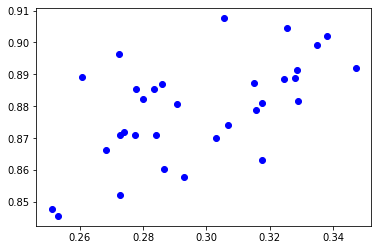

In [164]:
plt.plot(coef_list, metric_bl, 'bo')
plt.show()